In [17]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install scikit-learn
#!pip install xlrd
#!pip install -U imbalanced-learn

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
# import xlrd

from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Data

I am importing the data from Excel, then reporting a quick snapshot of the absolute number of defaults (6636) and non-defaults (23364), as well as the proportion of defaults (22%). Almost a fourth of individuals from this dataset default. For training, I save the attribute data into a variable, `X`, where I remove the impertinent ID column, and the label data is saved in a variable, `y_true`. The first few rows of these dataset are outputted for confirmation.

In [4]:
# import dataset
#data = pd.read_excel('./default of credit card clients.xls', header=1)
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/default of credit card clients.xls', header=1)
num_default = data['default payment next month'].sum()
num_no_default = data.shape[0] - num_default
default_ratio = num_default / (num_no_default + num_default)
print(f"# Default: {num_default:>8}\n# Repaid:  {num_no_default:>8}\n% Defaulters: {default_ratio:>5.2f}\n")

# assign variables
X = data.drop(['ID','default payment next month'], axis='columns') # removing ID column
y_true = data['default payment next month']
print(f"Attribute Data:\n\n{X.head()}\n\nLabel Data:\n\n{y_true.head()}")

# Default:     6636
# Repaid:     23364
% Defaulters:  0.22

Attribute Data:

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0     -2  ...        689          0          0          0         0       689   
1      0  ...       2682       3272       3455       3261         0      1000   
2      0  ...      13559      14331      14948      15549      1518      1500   
3      0  ...      49291      28314      28959      29547      2000      2019   
4      0  ...      35835      20940      19146      19131      200

# Implementing ML Algorithms to Predict Defaults

For my analysis, I take advantage of the scikit-learn library in Python. For all methods, I split my dataset into 80% training data and 20% test data. I chose not to work with a validation set; however, I implement certain methods that utilize built-in cross-validation, which breaks up the training dataset into mini validation sets.

# Addressing Data Imbalance

As reported above, the proportion of defaulters is 22%, while the proportion of non-defaulters is 78%. This imbalance in the data can lead to majority bias that can skew accuracy and recall metrics. To address this, I include a function, `generate_balanced_data`, that can be used to 'balance' the data by generating synthetic 'default' observations via interpolation. I ended up running through the code first without using this function for Logistica Regression, SVC, and Random Forest, then re-running the code using the function, for comparison.

**Note**: The run outputs displayed in the document and subsequent discussion are for the original (non-balanced) case. Imbalanced results are discussed at the end.

In [37]:
def generate_balanced_data(X, y_true, balance_data):
    if not balance_data:
        return train_test_split(X, y_true, test_size=0.2, random_state=25)
    else:
        # split data
        X_train_l_pre, X_test_l, y_train_l_pre, y_test_l = train_test_split(X, y_true, test_size=0.2, random_state=25)

        # apply SMOTE
        sm_l = SMOTE(random_state=25)
        X_train_l, y_train_l = sm_l.fit_resample(X_train_l_pre, y_train_l_pre)

        tot_before = sum(y_train_l_pre == 1)
        tot_after = sum(y_train_l == 1)
        print(f"# default (before): {tot_before}")
        print(f"# default (after): {tot_after}\n")

        return X_train_l, X_test_l, y_train_l, y_test_l

# Dummy Classifier (baseline)

I start by implementing a Dummy Classifier to serve as a baseline method against which to compare other methods. The Dummy Classifier generates the prediction of 0 or 1 at random, so we anticipate ~50% accuracy. I chose a `random_state=25`, which is the seed for the random number generator so the same results should be produced at each run. As expected, we see the training accuracy is 0.4966, which is ~50% accuracy.

In [ ]:
# split data
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_true, test_size=0.2, random_state=25)

# train
baseline = DummyClassifier(strategy='uniform')
baseline.fit(X_train_d,y_train_d)
accuracy_train_d = baseline.score(X_train_d, y_train_d)
print(f"Training Accuracy: {accuracy_train_d:0.4f} \n")

# test
y_pred_d = baseline.predict(X_test_d)
report_d = classification_report(y_test_d.to_numpy(), y_pred_d, digits=4)
print(f"Test Metrics:\n {report_d}")

Training Accuracy: 0.4966 

Test Metrics:
               precision    recall  f1-score   support

           0     0.7860    0.4977    0.6095      4649
           1     0.2359    0.5337    0.3272      1351

    accuracy                         0.5058      6000
   macro avg     0.5110    0.5157    0.4684      6000
weighted avg     0.6621    0.5058    0.5459      6000



## Dummy Classifier: Remarks

Above, I output a set of metrics for the test dataset, which includes accuracy, precision, recall, and F1-score. Accuracy for the test data is ~50%, as expected.

Precision is the number of correctly-classified defaulters in the (test) dataset divided by the total number of defaulters predicted by the model. I previously reported that there are 22% defaulters in our dataset. Therefore, we expect `precision = (0.5x0.22)/0.5 = 0.22`, which we see in the results. The numerator reflects true positives (defaults) since random sampling will predict 50% positive and our expectation of true positives reflects the population proportion (i.e., 22%); the denominator is the predicted-positives from our random labeling, which is 50%.

Recall is the number of correctly-classified defaulters divided by the total number of defaulters in the (test) dataset. We expect `recall = (0.5x0.22/0.22)`, which we see in the results.

F1-score is `(2*0.22*0.5)/(0.22+0.5) = 0.31` (see the formula of F1-score), which is also reflected in the results.

The macro average of a metric is the mean metric value for the labels 0 and 1, while the weighted average is the average weighted by the porportion of each label in the full dataset.

# Logistic Regression

I next try Logistic Regression to predict defaults. Data is preprocessed by standardizing features to zero mean and unit variance using `StandardScaler()` because features in some attributes had large variance relative to others. For the logistic regression algorithm, I used an L2 penalty because we have 30000 observations compared to 23 attributes, so I'm not looking to exclude attributes. I have also included the typical regularization step to address concerns of over-fitting.

Since hyperparameters can have a large influence on outcomes, I used `LogisticRegressionCV` because it has built-in cross-validation to select the best value for the `C` hyperparameter, which inversely influences the strength of the regularization. I felt the default value of 5 was fine for the number of stratifications in cross-validation (i.e., the proportion of data in the validation set), as well as the default value of 10 for the number of `C` values to sample. I output the sampled `C` values and report the best `C` value (2.78) used in the final estimation.

I then allow the algorithm to train and report a training accuracy of 0.81.

In [38]:
# split data
# set balance_data to True to apply Synthetic Minority Over-sampling Technique to address imbalance of defaulter proportion in full dataset
balance_data = False
X_train_l, X_test_l, y_train_l, y_test_l = generate_balanced_data(X, y_true, balance_data)

# preprocess data and train
pipe_l = make_pipeline(StandardScaler(), LogisticRegressionCV(random_state=25)) # default: L2 penalty, Stratified 5-Fold for cross-validation
pipe_l.fit(X_train_l, y_train_l)
accuracy_train_l = pipe_l.score(X_train_l, y_train_l)

# check C hyperparameter
grab_log_reg = pipe_l.named_steps['logisticregressioncv']
Cs_values = grab_log_reg.Cs_
coefficients = grab_log_reg.coefs_paths_
scores_C = grab_log_reg.scores_
best_C = grab_log_reg.C_

def sig_figs(x, sigs):
    return "{:.{p}g}".format(x, p=sigs)
C_vals_sampled = ", ".join(sig_figs(x, 3) for x in Cs_values)
print(f"Sampling C: [{C_vals_sampled}]")
print(f"Best C:      {best_C[0]:0.2f}\n")
print(f"Training Accuracy: {accuracy_train_l:0.4f} \n")

# test
y_pred_l = pipe_l.predict(X_test_l)
report_l = classification_report(y_test_l, y_pred_l, digits=4)
print(f"Test Metrics:\n {report_l}")

Sampling C: [0.0001, 0.000774, 0.00599, 0.0464, 0.359, 2.78, 21.5, 167, 1.29e+03, 1e+04]
Best C:      2.78

Training Accuracy: 0.8113 

Test Metrics:
               precision    recall  f1-score   support

           0     0.8151    0.9750    0.8880      4649
           1     0.7358    0.2391    0.3609      1351

    accuracy                         0.8093      6000
   macro avg     0.7755    0.6071    0.6244      6000
weighted avg     0.7973    0.8093    0.7693      6000



## Logistic Regression: Remarks

Above I report metrics for the test dataset, where we see similar accuracy (0.80). Precision is reasonable at 0.74; however, recall (or sensitivity, in binary classification) is poor (0.24). This implies that the current Logistic Regression approach has a higher chance of missing true defaulters, which is undesirable for banks. The model could be further tuned in an attempt to improve performance.

# Support Vector Classification (SVC)

Another classic approach - Support Vector Machines (specifically SVC for this problem). Again, I'm interested in sampling multiple hyperparameter values and using cross-validation to identify the best set, where cross-validation is built in to `GridSearchCV`. I'm opting to compare a linear kernel and an rbf kernel for the transformation portion of SVM because linear is simple and rbf is commonly used. I'm testing different `C` values but opting to use default for `gamma` (kernel coefficient) because it is adaptable to the dataset, i.e., `1 / (n_features * average_variance_across_features)`.

As in my Logistic Regression approach, I am also standardizing the features to zero mean and unit variance.

I was curious whether applying principle component analysis (PCA) for dimensionality reduction would improve accuracy, so I decided to throw in PCA into my pipeline, where I am adding `n_components` (number of components to keep) to my list of hyperparameters to test. To select the values, I considered the list of attributes and felt that they naturally fell into 8 categories. Therefore, I am moving forward with testing `n_components = 8 and 23`, where 23 is the complete set of attributes.

**Note**: Iteration information outputted below serve as a progress tracker.

In [40]:
# split data
# set balance_data to True to apply Synthetic Minority Over-sampling Technique to address imbalance of defaulter proportion in full dataset
balance_data = False
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_true, test_size=0.2, random_state=25)

# hyperparameter tuning and cross-validation
hyperparam_sampling = {
    'pca__n_components': [8, 23],
    'svc__C': [0.1, 1],
    'svc__kernel': ['linear', 'rbf']
}
pipe_s = make_pipeline(StandardScaler(), PCA(random_state=25), SVC(random_state=25))
tuning_s = GridSearchCV(pipe_s, hyperparam_sampling, verbose=2) # default: Stratified 5-Fold for cross-validation

# train
tuning_s.fit(X_train_s, y_train_s)
best_hyperparams_s = tuning_s.best_params_
print(f"\nBest parameters: {best_hyperparams_s}\n")
accuracy_train_s = tuning_s.score(X_train_s, y_train_s)
print(f"Training Accuracy: {accuracy_train_s:0.4f} \n")

# test
y_pred_s = tuning_s.predict(X_test_s)
report_s = classification_report(y_test_s, y_pred_s, digits=4)
print(f"Test Metrics:\n {report_s}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END pca__n_components=8, svc__C=0.1, svc__kernel=linear; total time=   7.9s
[CV] END pca__n_components=8, svc__C=0.1, svc__kernel=linear; total time=  11.7s
[CV] END pca__n_components=8, svc__C=0.1, svc__kernel=linear; total time=   8.1s
[CV] END pca__n_components=8, svc__C=0.1, svc__kernel=linear; total time=  12.0s
[CV] END pca__n_components=8, svc__C=0.1, svc__kernel=linear; total time=   8.9s
[CV] END ...pca__n_components=8, svc__C=0.1, svc__kernel=rbf; total time=  24.1s
[CV] END ...pca__n_components=8, svc__C=0.1, svc__kernel=rbf; total time=  16.1s
[CV] END ...pca__n_components=8, svc__C=0.1, svc__kernel=rbf; total time=  15.4s
[CV] END ...pca__n_components=8, svc__C=0.1, svc__kernel=rbf; total time=  23.2s
[CV] END ...pca__n_components=8, svc__C=0.1, svc__kernel=rbf; total time=  15.3s
[CV] END ..pca__n_components=8, svc__C=1, svc__kernel=linear; total time=  20.9s
[CV] END ..pca__n_components=8, svc__C=1, svc__ke

## SVC: Remarks

Best hyperparameters are reported above, namely: n_components = 32, C = 1, and kernel = rbf. It turns out my PCA hypothesis did not pan out and reducing the dimensionality to 8 did not outperform using all of the attributes in the model. I'm not surprised that the rbf kernel outperformed linear.

Overall performance of the SVC algorithm improved relative to Logistic Regression, with an accuracy of 0.82 and other metrics listed above.

# Random Forest

I went with Random Forest over Decision Trees as my last method because I assumed I have enough computing power for a Random Forest, which performs better than a Decision Tree with less for over-fitting. I chose to explore three hyperparameters: `n_estimators` (# of trees), `max_depth` (max distance between root node and leaf node), and `min_samples_split` (min # of samples to split a node), and I again used cross-validation built in to `GridSearchCV`. My choice for hyperparameter values was based on recommendations online and trial and error.

**Note**: Iteration information outputted below serve as a progress tracker.

In [43]:
# split data
# set balance_data to True to apply Synthetic Minority Over-sampling Technique to address imbalance of defaulter proportion in full dataset
balance_data = False
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_true, test_size=0.2, random_state=25)

# hyperparameter tuning and cross-validation
hyperparam_sampling = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10]
}
tuning_r = GridSearchCV(estimator=RandomForestClassifier(random_state=25), param_grid=hyperparam_sampling, verbose=2) # default: Stratified 5-Fold for cross-validation

# train
tuning_r.fit(X_train_r, y_train_r)
best_hyperparams_r = tuning_r.best_params_
print(f"\nBest parameters: {best_hyperparams_r}\n")
accuracy_train_r = tuning_r.score(X_train_r, y_train_r)
print(f"Training Accuracy: {accuracy_train_r:0.4f} \n")

# test
y_pred_r = tuning_r.predict(X_test_r)
report_r = classification_report(y_test_r, y_pred_r, digits=4)
print(f"Test Metrics:\n {report_r}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.7s
[CV] END max_depth=10, min_samples_split=2, n_e

## Random Forest: Remarks

The best parameters were `n_estimators` = 200, `max_depth` = 10, `min_samples_split` = 2. It makes sense that a greater number of trees performs better, and a max_depth of 10 likely minimized over-fitting. Accuracy was again reasonable, at 0.82, with other metrics listed above.

# Comparing Methods

Below are two plots (with and without data balancing) comparing 5 metrics for all four ML methods.

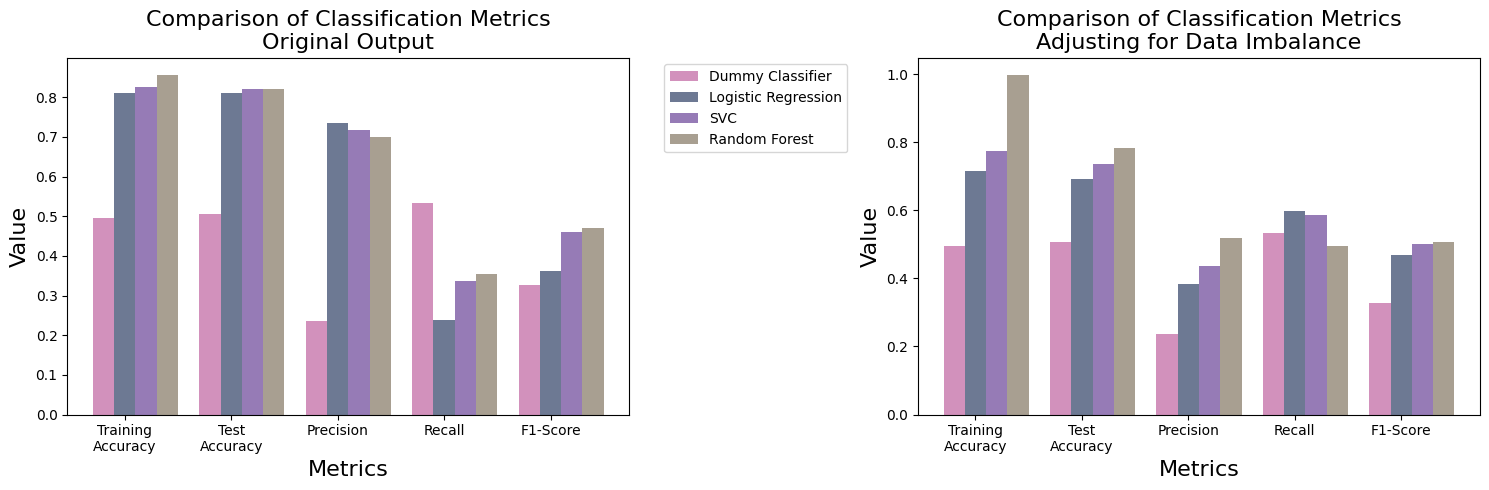

In [45]:
# plot histogram of metrics
metrics = ['Training\nAccuracy', 'Test\nAccuracy', 'Precision', 'Recall', 'F1-Score']
# original run
dum = [0.4966, 0.5058, 0.2359, 0.5337, 0.3272]
logr = [0.8113, 0.8093, 0.7358, 0.2391, 0.3609]
svc = [0.8250, 0.8210, 0.7181, 0.3375, 0.4592]
randf = [0.8571, 0.8200, 0.6984, 0.3531, 0.4690]
# adjusted for data imbalance
logr_a = [0.7170, 0.6927, 0.3832, 0.5988, 0.4674]
svc_a = [0.7734, 0.7363, 0.4364, 0.5870, 0.5006]
randf_a = [0.9992, 0.7835, 0.5202, 0.4952, 0.5074]

x = np.arange(len(metrics))
bar_width = 0.2
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
cols = ['#D291BC', '#6D7993', '#967BB6', '#A89F91', '#75B9BE']

r1 = np.arange(len(dum))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

axs[0].bar(r1, dum, width=bar_width, label='Dummy Classifier', color=cols[0])
axs[0].bar(r2, logr, width=bar_width, label='Logistic Regression', color=cols[1])
axs[0].bar(r3, svc, width=bar_width, label='SVC', color=cols[2])
axs[0].bar(r4, randf, width=bar_width, label='Random Forest', color=cols[3])

axs[0].set_xlabel('Metrics', fontsize=16)
axs[0].set_ylabel('Value', fontsize=16)
axs[0].set_title('Comparison of Classification Metrics\nOriginal Output', fontsize=16)
axs[0].set_xticks([r + bar_width for r in range(len(dum))], metrics)
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axs[1].bar(r1, dum, width=bar_width, label='Dummy Classifier', color=cols[0])
axs[1].bar(r2, logr_a, width=bar_width, label='Logistic Regression', color=cols[1])
axs[1].bar(r3, svc_a, width=bar_width, label='SVC', color=cols[2])
axs[1].bar(r4, randf_a, width=bar_width, label='Random Forest', color=cols[3])

axs[1].set_xlabel('Metrics', fontsize=16)
axs[1].set_ylabel('Value', fontsize=16)
axs[1].set_title('Comparison of Classification Metrics\nAdjusting for Data Imbalance', fontsize=16)
axs[1].set_xticks([r + bar_width for r in range(len(dum))], metrics)

fig.tight_layout()

plt.show()

# Interpretting Results

### Original Output (left)
In the plots above, the Dummy Classifier serves as our baseline by which to compare the other three primary classifiers. We see that all primary methods achieved around 80% accuracy, and similarity between training and test accuracy suggests over-fitting was not an issue. Precision was also reasonable, hovering around 70% for the primary methods. The recall metric, however, was worse for all primary classifiers compared to baseline. This result motivated the exploration into balancing the data.

### Adjusting for Data Imbalance (right)
After balancing the data for the primary classifiers, I immediately notice that Random Forest has a training accuracy close to 1, while the test accuracy is close to 0.8. This discrepancy suggests there was an issue with over-fitting. For Random Forest, the best parameters were: `n_estimators = 200`, `max_depth = 30`, `min_samples_split = 2`. A larger depth may contribute to over-fitting.

Overall, however, we do see an improvement in recall for all primary methods at the expense of decreased accuracy, which likely reflects a minimization of bias. Despite having the largest accuracy, Random Forest has the lowest recall, even relative to the dummy classifier. Since banks may prefer to prioritize recall over accuracy (to ensure that all would-be defaulters are identified), I may prefer SVC over Random Forest for this task.

# Final Remarks

If my aim were to continue searching for better classification, I could dive further into the weeds by exploring colinearity of attributes, additional dimensionality reduction, etc. for the methods above. I could also consider additional preprocessing steps, like normalizing `BILL_AMT#` by `LIMIT_BAL`. With more time, I would like to explore the performance of additional machine learning algorithms.  I have experience with clustering algorithms (e.g., K-means, HDBSCAN, tSNE), so I would start there.

To test for statistical significance, I would run each method 10 times and perform a one-way ANOVA on metric data across methods.

